В этом ноутбуке мы:

1. Загружаем обученную сеть (`best_model.pth`);
2. Обрабатываем видео MP4 кадр-за-кадром;
3. Сохраняем оverlay-ролик с полупрозрачной маской.

импорты и helpers

In [61]:
import cv2, torch, numpy as np, time, os, itertools, sys
from pathlib import Path
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset, DataLoader

DEVICE   = "mps" if torch.backends.mps.is_available() else "cpu"
WEIGHTS  = Path("../src/best_model.pth")       # поправьте путь
VIDEO_IN = Path("../samples/input.mp4")    # входное видео
VIDEO_OUT= Path("../results/drive_overlay.mp4")
SIZE     = 1024                            # длинная сторона, px
root   = Path.cwd().parent
CITY   = root / "data" / "cityscapes"
POTH   = root / "data" / "potholes"

CLR = np.array([[0,0,0],[0,255,0],[255,0,0],[0,0,255]], np.uint8)  # BGR цвета

def build_transform(max_side=SIZE):
    return A.Compose([
        A.LongestMaxSize(max_size=max_side),
        A.PadIfNeeded(max_side, max_side, border_mode=0, value=(0,0,0)),
        ToTensorV2()
    ])

загрузка модели

In [62]:
model = smp.DeepLabV3Plus(
    encoder_name="resnet50",
    classes=4,
    activation=None,
)
state = torch.load(WEIGHTS, map_location="cpu")
model.load_state_dict(state, strict=False)
model.to(DEVICE, dtype=torch.float32).eval()

print("модель загружена, устройство:", DEVICE)

модель загружена, устройство: mps


Тест на одиночном изображении

In [63]:
class RoadDataset(Dataset):
    def __init__(self, img_paths, mask_paths, train=True):
        self.imgs  = img_paths
        self.masks = mask_paths
        tf_train = A.Compose([
    A.RandomScale(scale_limit=(0.7, 2.0), p=1.0),
    A.RandomRotate90(p=0.5),
    A.RandomCrop(512, 512),
    A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.2),
    A.RandomBrightnessContrast(0.3, 0.3, p=0.3),
    ToTensorV2()
])
        tf_val = A.Compose([
    A.LongestMaxSize(max_size=512),
    A.PadIfNeeded(512, 512),
    ToTensorV2()
])
        self.tf = tf_train if train else tf_val

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img  = cv2.cvtColor(cv2.imread(str(self.imgs[idx])), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(str(self.masks[idx]), cv2.IMREAD_UNCHANGED)
        aug = self.tf(image=img, mask=mask)
        x = aug["image"].float() / 255.0      # [0,1]
        y = aug["mask"].long()
        return x, y

In [64]:
from pathlib import Path
VAL_IMG_SAMPLE = next((CITY/'images/leftImg8bit/val').rglob('*_leftImg8bit.png'))
print("sample img :", VAL_IMG_SAMPLE)

VAL_MASK_EXPECTED = Path(str(VAL_IMG_SAMPLE)
    .replace("/images/leftImg8bit/", "/masks/gtFine/")   # каталог OK
    .replace("_leftImg8bit", "_gtFine_ourIds"))
print("expected mask :", VAL_MASK_EXPECTED, VAL_MASK_EXPECTED.exists())

sample img : /Users/macbook/projects/road_seg/data/cityscapes/images/leftImg8bit/val/munster/munster_000025_000019_leftImg8bit.png
expected mask : /Users/macbook/projects/road_seg/data/cityscapes/masks/gtFine/val/munster/munster_000025_000019_gtFine_ourIds.png True


In [65]:
# --- Cityscapes -------------------------------------------------------------
def make_city_pairs(split):
    pairs = []
    for m in (CITY / "masks/gtFine" / split).rglob("*_ourIds.png"):
        img = Path(str(m)
                   .replace("/masks/gtFine/", "/images/leftImg8bit/")
                   .replace("_gtFine_ourIds", "_leftImg8bit"))
        if img.exists():
            pairs.append((img, m))
    return pairs

city_train_pairs = make_city_pairs("train")
city_val_pairs   = make_city_pairs("val")

# --- Pothole ----------------------------------------------------------------
poth_pairs = [
    (img, (POTH / "masks_png" / (img.stem + ".png")))
    for img in (POTH / "images").glob("*.jpg")
    if (POTH / "masks_png" / (img.stem + ".png")).exists()
]

# --- oversample кадры с ямами ----------------------------------------------
import cv2, random
rare_pairs = [
    p for p in poth_pairs
    if (cv2.imread(str(p[1]), cv2.IMREAD_UNCHANGED) == 3).any()
]

train_pairs = city_train_pairs + poth_pairs + rare_pairs * 4
random.shuffle(train_pairs)
val_pairs   = city_val_pairs

assert train_pairs, "train_pairs пуст!"
assert val_pairs,   "val_pairs   пуст!"

train_imgs, train_masks = zip(*train_pairs)
val_imgs,   val_masks   = zip(*val_pairs)

print(f"Train {len(train_imgs)}  |  Val {len(val_imgs)}")

Train 7466  |  Val 500


In [66]:
train_ds = RoadDataset(train_imgs, train_masks, train=True)
val_ds   = RoadDataset(val_imgs,   val_masks,   train=False)

loader_tr = DataLoader(train_ds, batch_size=4, shuffle=True,  num_workers=0, pin_memory=True)
loader_va = DataLoader(val_ds,   batch_size=4, shuffle=False, num_workers=0, pin_memory=True)

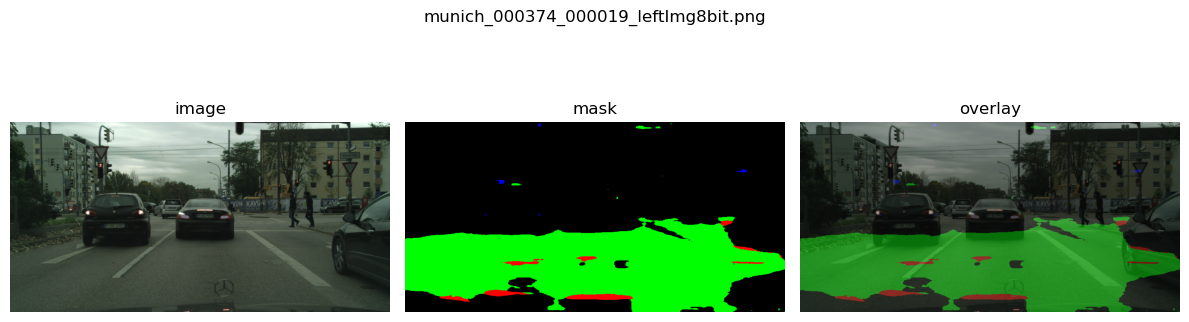

In [67]:
import cv2, torch, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
import albumentations as A
from albumentations.pytorch import ToTensorV2

DEVICE = 'mps' if torch.backends.mps.is_available() else 'cpu'
COLORS = np.array([[0,0,0], [0,255,0], [255,0,0], [0,0,255]], np.uint8)  # RGB

# -------- валид-трансформация (как в обучении) ------------------------
tf_val = A.Compose([
    A.LongestMaxSize(max_size=512),
    A.PadIfNeeded(512, 512, border_mode=0, value=(0,0,0)),
    ToTensorV2()
])

# -------- читаем кадр --------------------------------------------------
img_path = Path('/Users/macbook/projects/road_seg/data/cityscapes/images/leftImg8bit/test/munich/munich_000374_000019_leftImg8bit.png')
raw = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
aug = val_ds.tf(image=raw)["image"].unsqueeze(0).to(DEVICE) / 255.
orig_rgb = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
h0, w0   = orig_rgb.shape[:2]

# -------- применяем tf_val --------------------------------------------
sample = tf_val(image=orig_rgb)
inp    = sample['image'].unsqueeze(0).to(DEVICE)          # БЕЗ «/ 255»!
                                                             # ToTensorV2 уже переводит 0-255 → 0-1
# -------- инференс -----------------------------------------------------
model.eval()
with torch.no_grad():
    pred = model(aug).argmax(1).cpu()[0]

# -------- убираем паддинг и растягиваем -------------------------------
pad = (512 - sample['image'].shape[1]) // 2          # 128
mask_crop = pred[pad : pad+sample['image'].shape[1], :sample['image'].shape[2]]

mask_crop = mask_crop.detach().cpu().numpy().astype(np.uint8)               # 🔑 гарантируем ndarray
mask_rgb  = COLORS[mask_crop]                        # (H',W',3) uint8

# -------- растягиваем к исходному размеру -----------------------------
mask_rgb = cv2.resize(
    mask_rgb,          # (H',W',3)
    (w0, h0),          # целевой размер
    interpolation=cv2.INTER_NEAREST
) 
mask_full = cv2.resize(mask_crop, (w0, h0), interpolation=cv2.INTER_NEAREST)

overlay = cv2.addWeighted(orig_rgb, 0.6, mask_rgb, 0.4, 0)

# ---------- визyализация ----------------------------------------------
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(orig_rgb); plt.title('image');   plt.axis('off')
plt.subplot(1,3,2); plt.imshow(mask_rgb);  plt.title('mask');    plt.axis('off')
plt.subplot(1,3,3); plt.imshow(overlay);  plt.title('overlay'); plt.axis('off')
plt.suptitle(img_path.name); plt.tight_layout(); plt.show()

открываем видео и подготовка IO

In [68]:
# ---------- params ----------------------------------------------------
VIDEO_IN  = Path('/Users/macbook/projects/road_seg/samples/input.mp4')
VIDEO_OUT = Path('/Users/macbook/projects/road_seg/results/drive_overlay.mp4')
DEVICE    = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

CLR = np.array([[0,0,0],[0,255,0],[255,0,0],[0,0,255]], np.uint8)   # RGB

# ---------- open video ------------------------------------------------
cap = cv2.VideoCapture(str(VIDEO_IN))
assert cap.isOpened(), f"не удалось открыть {VIDEO_IN}"

fps_in = cap.get(cv2.CAP_PROP_FPS)
w0     = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h0     = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
print(f"{VIDEO_IN.name}: {w0}×{h0}  {fps_in:.1f} fps")

# ---------- writer (будет 10 fps) ------------------------------------
fourcc   = cv2.VideoWriter_fourcc(*"mp4v")
fps_out  = min(10, fps_in)                     # ограничим
out      = cv2.VideoWriter(str(VIDEO_OUT), fourcc, fps_out, (w0, h0))

# ---------- валид-трансформации (768px, без паддинга) -----------------
import albumentations as A
from albumentations.pytorch import ToTensorV2

def build_transform():
    return A.Compose([
        A.LongestMaxSize(max_size=768),        # >512 → меньше смятия
        ToTensorV2()
    ])
tf_val = build_transform()

input.mp4: 1280×720  30.0 fps


петля инференса

In [70]:
import time, cv2, torch, numpy as np
from pathlib import Path
import albumentations as A
from albumentations.pytorch import ToTensorV2

# ------------ параметры ----------------------------------------------
VIDEO_IN  = Path("/Users/macbook/projects/road_seg/samples/input.mp4")
VIDEO_OUT = Path("/Users/macbook/projects/road_seg/results/drive_overlay.mp4")
DEVICE    = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
BATCH     = 2
SIDE_IN   = 1024                          # crop-slide ширины
FPS_OUT   = 20
TH_PROAD  = 0.32                         # softmax-порог для дороги
TH_POBST  = 0.53                         # красные препятствия / ямы
horizon1 = int(pred.shape[0] * 0.50)
horizon2 = int(pred.shape[0] * 0.30)
bottom = int(pred.shape[0] * 0.05)          # 5 % высоты 

COLORS = np.array([[0,0,0], [0,255,0], [255,0,0], [0,0,255]], np.uint8)  # RGB

# ------------ трансформации ------------------------------------------
preproc = A.Compose([
    # фиксируем размер по высоте 512, центр-crop 1024×512
    A.LongestMaxSize(max_size=SIDE_IN),         # downscale ~1.2×
    A.CenterCrop(height=512, width=SIDE_IN),    # 1024×512
    A.CLAHE(clip_limit=3.0, tile_grid_size=(8, 8), p=1.0),
    A.RandomGamma(gamma_limit=(90, 110), p=1.0),    # чуть осветлить
    ToTensorV2()
])

kernel5 = np.ones((5,5), np.uint8)             # морфология

# ------------ вход-/выход видео --------------------------------------
cap = cv2.VideoCapture(str(VIDEO_IN));  assert cap.isOpened()
fps_in = cap.get(cv2.CAP_PROP_FPS)
w0, h0 = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out    = cv2.VideoWriter(str(VIDEO_OUT), fourcc, min(FPS_OUT, fps_in), (w0, h0))
print(f"{VIDEO_IN.name}: {w0}×{h0}  {fps_in:.1f} fps  →  overlay@{FPS_OUT}fps")

# ------------ цикл ----------------------------------------------------
frames, t0 = 0, time.time()
with torch.no_grad():
    while True:
        imgs, bgr_list = [], []
        for _ in range(BATCH):
            ok, bgr = cap.read()
            if not ok:
                break
            bgr_list.append(bgr)
            rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
            imgs.append(preproc(image=rgb)["image"])

        if len(imgs) == 0:
            break

        inp = torch.stack(imgs).float().to(DEVICE) / 255.
        with torch.autocast(device_type="mps"):
            logits = model(inp)                       # (B,4,H,W)
            prob   = logits.softmax(1).cpu()

        for bgr, p in zip(bgr_list, prob):
            # ---------------------------------------------
            pred = p.argmax(0).numpy().astype(np.uint8)   # базовый argmax

            # ----- доверяем дороге, если prob_road > TH_PROAD ----------
            road_map = (p[1] > TH_PROAD).numpy()
            pred[(pred != 1) & road_map] = 1
            pred[:horizon1, :][pred[:horizon1, :] == 1] = 0

            # ----- доверяем препятствию, если prob_obst > TH_POBST -----
            obst_map = (p[2] > TH_POBST).numpy()
            pred[(pred != 2) & obst_map] = 2
            pred[:horizon2, :][pred[:horizon2, :] == 2] = 0

            # -------- морфология + largest blob ----------------------
            pred = cv2.morphologyEx(pred, cv2.MORPH_CLOSE, kernel5)
            pred = cv2.morphologyEx(pred, cv2.MORPH_OPEN,  kernel5)

             # (оставляем самый крупный участок дороги, как раньше)
            road = (pred == 1).astype(np.uint8)
            n, lbl, stats, _ = cv2.connectedComponentsWithStats(road, 8)
            if n > 1:
                max_id = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
                pred[(pred == 1) & (lbl != max_id)] = 0

            pred[-bottom:, :] = 0

            # -------- ресайз к исходнику и overlay -------------------
            mask_rgb = cv2.resize(COLORS[pred], (w0, h0), cv2.INTER_NEAREST)
            blend    = cv2.addWeighted(bgr, 0.6, mask_rgb, 0.4, 0)
            out.write(blend);  frames += 1

cap.release();  out.release()
print(f"✔ {frames} кадров, {time.time()-t0:.1f} s  →  {VIDEO_OUT}")


input.mp4: 1280×720  30.0 fps  →  overlay@20fps
✔ 1204 кадров, 501.1 s  →  /Users/macbook/projects/road_seg/results/drive_overlay.mp4


просмотр первого кадра результата

In [ ]:
from IPython.display import Video
Video(str(VIDEO_OUT), embed=True, width=640)